Utilizing historical taxi trip data sourced from the NYC Taxi and Limousine Commission (TLC), spanning January 2021 to August 2022, our project aims to analyze payment methods and assess car demand trends over the specified timeframe.

Through rigorous data exploration, cleansing processes, and the application of advanced analytical techniques and visualization tools, we seek to uncover valuable insights into payment preferences and fluctuations in car demand within the specified period.

To commence our analysis, we'll begin by importing the necessary libraries and uploading the dataset for further examination.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pandasql import sqldf

## Load Data

In [2]:
taxi_zone = pd.read_csv("./raw/taxi_zone.csv")
calendar = pd.read_csv("./raw/calendar.csv")
vendor = pd.read_csv("./raw/vendor.csv")
trip_type = pd.read_csv("./raw/trip_type.tsv", sep="\t")
payment_type = pd.read_json("./raw/payment_type.json", lines=True)

In [3]:
taxi_zone.head(2)

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone


In [4]:
calendar.head(2)

,date_key,date,year,month,day,day_name,day_of_year,week_of_month,week_of_year,month_name,year_month,year_week
0,20200101,2020-01-01,2020,1,1,Wednesday,1,1,1,January,202001,202001
1,20200102,2020-01-02,2020,1,2,Thursday,2,1,1,January,202001,202001


In [5]:
vendor.head(2)

,vendor_id,vendor_name
0,1,"Creative Mobile Technologies, LLC"
1,2,VeriFone Inc


In [6]:
trip_type.head(2)

,trip_type,trip_type_desc
0,1,Street-hail
1,2,Dispatch


## Transform Data

In [7]:
payment_type.rename(columns={"payment_type_desc": "description"}, inplace=True)

In [8]:
# function to read all trip data from folder trip_data_green_csv
def read_trip_data():
    dfs = []
    for year_dir in os.listdir("./raw/trip_data_green_csv"):
        if year_dir.startswith('year='):
            # Path to the year directory
            year_path = os.path.join("./raw/trip_data_green_csv", year_dir)

            # Iterate over the directories for each month
            for month_dir in os.listdir(year_path):
                # Path to the month directory
                if month_dir == ".DS_Store":
                    continue
                month_path = os.path.join(year_path, month_dir)

                # Iterate over the files in the month directory
                for file in os.listdir(month_path):
                    # Check if the file is a CSV file
                    if file.endswith('.csv'):
                        # Path to the CSV file
                        file_path = os.path.join(month_path, file)

                        # Read the CSV file into a DataFrame
                        df = pd.read_csv(file_path)

                        # Append the DataFrame to the list
                        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)
trip_data = read_trip_data()

/Users/LongLH/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [9]:
trip_data.head(2)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2.0,2020-03-01 00:20:18,2020-03-01 00:45:29,N,1.0,41,13,1.0,8.24,26.5,0.5,0.5,7.64,0.0,NaN,0.3,38.19,1.0,1.0,2.75
1,2.0,2020-03-01 00:15:42,2020-03-01 00:44:36,N,1.0,181,107,1.0,4.87,21.0,0.5,0.5,0.00,0.0,NaN,0.3,25.05,2.0,1.0,2.75


In [10]:
trip_data["lpep_pickup_datetime"] = pd.to_datetime(trip_data["lpep_pickup_datetime"])
trip_data["lpep_dropoff_datetime"] = pd.to_datetime(trip_data["lpep_dropoff_datetime"])

In [11]:
trip_data["trip_duration"] = (trip_data["lpep_dropoff_datetime"] -  trip_data["lpep_pickup_datetime"]).dt.total_seconds() / 60

In [12]:
trip_data["year"] = trip_data['lpep_pickup_datetime'].dt.year
trip_data["month"] = trip_data['lpep_pickup_datetime'].dt.month

In [13]:
trip_data["trip_date"] = trip_data["lpep_pickup_datetime"].dt.date

In [14]:
trip_data.rename(columns={"VendorID": "vendor_id", "RatecodeID": "rate_code_id", "PULocationID": "pu_location_id", "DOLocationID": "do_location_id"}, inplace=True)

In [15]:
taxi_zone.rename(columns={"LocationID": "location_id", "Borough": "borough", "Zone": "zone"}, inplace=True)

In [16]:
calendar.columns

Index(['date_key', 'date', 'year', 'month', 'day', 'day_name', 'day_of_year',
       'week_of_month', 'week_of_year', 'month_name', 'year_month',
       'year_week'],
      dtype='object')

In [17]:
payment_type.columns

Index(['payment_type', 'description'], dtype='object')

In [18]:
trip_type.columns

Index(['trip_type', 'trip_type_desc'], dtype='object')

## Aggregate Data

In [19]:
result_dominant_teams = sqldf("""
SELECT td.year,
       td.month,
       tz.borough,
       td.trip_date,
       cal.day_name AS trip_day,
       CASE WHEN cal.day_name IN ('Saturday','Sunday') THEN 'Y' ELSE 'N' END AS trip_day_weekend_ind,
       SUM(CASE WHEN pt.description = 'Credit card' THEN 1 ELSE 0 END) AS card_trip_count,
       SUM(CASE WHEN pt.description = 'Cash' THEN 1 ELSE 0 END) AS cash_trip_count,
       SUM(CASE WHEN tt.trip_type_desc = 'Street-hail' THEN 1 ELSE 0 END) AS street_hail_trip_count,
       SUM(CASE WHEN tt.trip_type_desc = 'Dispatch' THEN 1 ELSE 0 END) AS dispatch_trip_count ,
       SUM(td.trip_distance) AS trip_distance,
       SUM(td.trip_duration) AS trip_duration,
       SUM(td.fare_amount) AS fare_amount
  FROM trip_data td
  JOIN taxi_zone tz ON (td.pu_location_id = tz.location_id)
  JOIN calendar cal ON (cal.date = td.trip_date)
  JOIN payment_type pt ON (td.payment_type = pt.payment_type)
  JOIN trip_type tt ON (td.trip_type = tt.trip_type)
GROUP BY td.year,
       td.month,
       tz.borough,
       td.trip_date,
       cal.day_name;
""")

In [20]:
result_dominant_teams.head(2)

,year,month,borough,trip_date,trip_day,trip_day_weekend_ind,card_trip_count,cash_trip_count,street_hail_trip_count,dispatch_trip_count,trip_distance,trip_duration,fare_amount
0,2020,1,Bronx,2020-01-01,Wednesday,N,137,209,293,56,1482.37,6326.933333,5955.61
1,2020,1,Bronx,2020-01-02,Thursday,N,191,178,329,45,1461.77,7641.266667,6050.78


In [21]:
result_dominant_teams.columns

Index(['year', 'month', 'borough', 'trip_date', 'trip_day',
       'trip_day_weekend_ind', 'card_trip_count', 'cash_trip_count',
       'street_hail_trip_count', 'dispatch_trip_count', 'trip_distance',
       'trip_duration', 'fare_amount'],
      dtype='object')

## Visualization

### Payment Type Report

In [22]:
df_grouped = result_dominant_teams.groupby('trip_day')[['card_trip_count', 'cash_trip_count']].sum().reset_index()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert 'trip_day' to categorical data with the specified order
df_grouped['trip_day'] = pd.Categorical(df_grouped['trip_day'], categories=day_order, ordered=True)

# Sort the DataFrame by the categorical 'trip_day' column
df_sorted = df_grouped.sort_values(by='trip_day')
df_sorted["trip_day"] = df_sorted["trip_day"].astype(str)

In [23]:
df_sorted.head(1000)

,trip_day,card_trip_count,cash_trip_count
1,Monday,114820,87938
5,Tuesday,122371,89917
6,Wednesday,132658,97897
4,Thursday,135952,100902
0,Friday,138449,109345
2,Saturday,117659,100199
3,Sunday,94102,72587


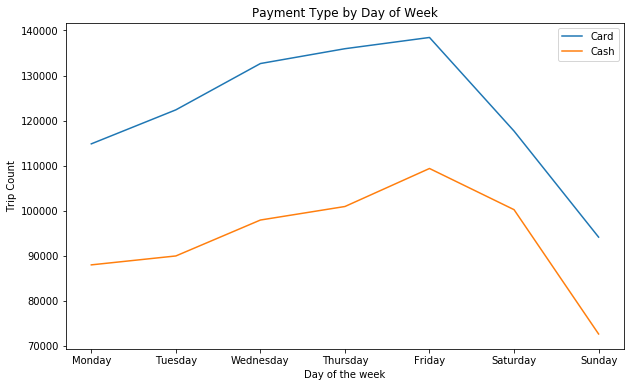

In [24]:
# Plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['trip_day'], df_sorted['card_trip_count'], label='Card')
plt.plot(df_sorted['trip_day'], df_sorted['cash_trip_count'], label='Cash')
plt.xlabel('Day of the week')
plt.ylabel('Trip Count')
plt.title('Payment Type by Day of Week')
plt.legend()
plt.show()

#### Weekly Trip Analysis by Payment Method

- Card vs. Cash: Card transactions consistently outnumber cash payments across all weekdays.
- Peak Days: Wednesdays and Fridays see the highest total trip counts, predominantly driven by card transactions.

#### Insights:

- Card transactions dominate, suggesting a preference for electronic payments.
- Operational strategies should consider weekday peaks and weekend dynamics to optimize service provision and resource allocation.

In [25]:
result_dominant_teams.dtypes

year                        int64
month                       int64
borough                    object
trip_date                  object
trip_day                   object
trip_day_weekend_ind       object
card_trip_count             int64
cash_trip_count             int64
street_hail_trip_count      int64
dispatch_trip_count         int64
trip_distance             float64
trip_duration             float64
fare_amount               float64
dtype: object

In [26]:
result_dominant_teams["year_month"] = result_dominant_teams["year"].astype(str) + "-" + result_dominant_teams["month"].astype(str)
df_grouped = result_dominant_teams.groupby('year_month')[['card_trip_count', 'cash_trip_count']].sum().reset_index()

month_order = ['2020-1', '2020-2', '2020-3', '2020-4', '2020-5', '2020-6', '2020-7', '2020-8', '2020-9', '2020-10', '2020-11', '2020-12', '2021-1', '2021-2', '2021-3', '2021-4', '2021-5', '2021-6', '2021-7', '2021-8']

df_grouped['year_month'] = pd.Categorical(df_grouped['year_month'], categories=month_order, ordered=True)

df_sorted = df_grouped.sort_values(by='year_month')
df_sorted["year_month"] = df_sorted["year_month"].astype(str)
df_sorted = df_sorted[df_sorted['year_month'] != '2021-8']

In [27]:
df_sorted.head(50)

,year_month,card_trip_count,cash_trip_count
0,2020-1,184392,144996
4,2020-2,176532,138858
5,2020-3,93162,81623
6,2020-4,12269,11954
7,2020-5,15596,15355
8,2020-6,20305,17701
9,2020-7,23493,19350
10,2020-8,25627,20670
11,2020-9,27162,21014
1,2020-10,30009,22105


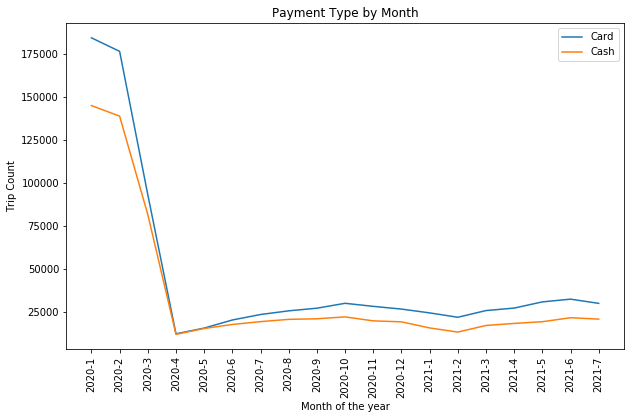

In [28]:
# Plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['year_month'], df_sorted['card_trip_count'], label='Card')
plt.plot(df_sorted['year_month'], df_sorted['cash_trip_count'], label='Cash')
plt.xlabel('Month of the year')
plt.ylabel('Trip Count')
plt.title('Payment Type by Month')
plt.xticks(rotation=90)
plt.legend()
plt.show()

#### Monthly Trip Analysis by Payment Method (2020-2021)

- Card vs. Cash: Throughout 2020 and 2021, card transactions consistently exceeded cash payments.
- Yearly Trends: Total trip counts sharply declined from April 2020 to July 2021, reflecting the significant influence of COVID-19 on travel behavior and mobility patterns during this period.

#### Insights:

- The dataset reflects fluctuations in consumer behavior over the two-year period, indicating potential factors influencing payment preferences.
- Understanding these trends can aid in forecasting demand and tailoring marketing strategies to optimize revenue.

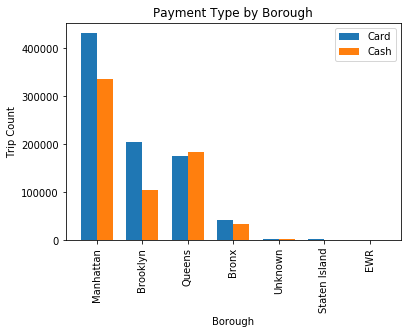

In [29]:
df_grouped = result_dominant_teams.groupby('borough')[['card_trip_count', 'cash_trip_count']].sum().reset_index()
df_grouped = df_grouped.sort_values(by='card_trip_count', ascending=False)
# Get boroughs and payment types
boroughs = df_grouped.borough.unique()
payment_types = df_grouped.columns

# Get trip counts for each payment type
card_counts = df_grouped['card_trip_count']
cash_counts = df_grouped['cash_trip_count']

# Plotting
fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(boroughs))

# Plot bars for card trip counts
bar1 = ax.bar(index, card_counts, bar_width, label='Card')

# Plot bars for cash trip counts
bar2 = ax.bar([i + bar_width for i in index], cash_counts, bar_width, label='Cash')

ax.set_xlabel('Borough')
ax.set_ylabel('Trip Count')
ax.set_title('Payment Type by Borough')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(boroughs)
ax.set_xticklabels(boroughs, rotation=90)
ax.legend()

plt.show()

#### Borough-wise Trip Analysis by Payment Method:

- Card vs. Cash: Card transactions generally surpass cash payments across all boroughs.
- Top Performers: Manhattan and Brooklyn exhibit the highest total trip counts, with card transactions dominating.
- Minor Contributors: Other boroughs, such as Queens and the Bronx, also demonstrate substantial trip activity, predominantly via card payments.

#### Insights:

- Manhattan emerges as the primary hub for taxi trips, with both card and cash transactions significantly contributing to its high trip counts.
- Brooklyn follows closely behind, indicating a robust demand for taxi services in this borough as well.

### Car Demand Report

In [30]:
result_dominant_teams["trip_count"] = result_dominant_teams["card_trip_count"] + result_dominant_teams["cash_trip_count"]

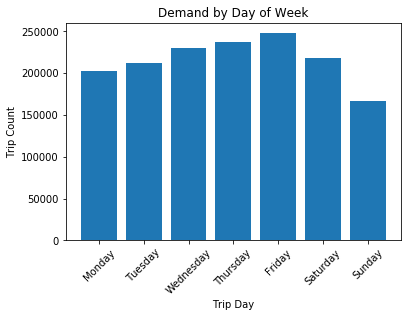

In [31]:
df_grouped = result_dominant_teams.groupby('trip_day')[['trip_count']].sum().reset_index()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert 'trip_day' to categorical data with the specified order
df_grouped['trip_day'] = pd.Categorical(df_grouped['trip_day'], categories=day_order, ordered=True)

# Sort the DataFrame by the categorical 'trip_day' column
df_sorted = df_grouped.sort_values(by='trip_day')
df_sorted["trip_day"] = df_sorted["trip_day"].astype(str)

# Plot using Matplotlib
plt.bar(df_sorted['trip_day'], df_sorted['trip_count'])
plt.xlabel('Trip Day')
plt.ylabel('Trip Count')
plt.title('Demand by Day of Week')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

#### Weekly Trip Counts:

- Peak Activity: Thursdays and Fridays exhibit the highest trip counts, with 236,854 and 247,794 trips respectively.
- Weekend Patterns: Trip counts decrease notably on Sundays, with 166,689 trips recorded, marking the lowest activity of the week.
- Consistent Trends: Trip counts generally increase from Monday to Friday, peaking towards the end of the workweek.

#### Insights:

- Understanding weekly trip patterns can aid in optimizing service provision and resource allocation to meet fluctuating demand throughout the week.

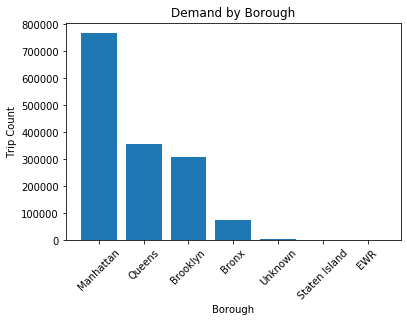

In [32]:
df_grouped = result_dominant_teams.groupby('borough')[['trip_count']].sum().reset_index()

# Sort the DataFrame by the categorical 'trip_count' column
df_sorted = df_grouped.sort_values(by='trip_count', ascending=False)

# Plot using Matplotlib
plt.bar(df_sorted['borough'], df_sorted['trip_count'])
plt.xlabel('Borough')
plt.ylabel('Trip Count')
plt.title('Demand by Borough')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [33]:
df_sorted.head(100)

,borough,trip_count
3,Manhattan,766980
4,Queens,357156
1,Brooklyn,307478
0,Bronx,75908
6,Unknown,5229
5,Staten Island,2013
2,EWR,32


#### Borough-wise Trip Counts:

- Manhattan Dominance: Manhattan leads in trip counts with 766,980 trips, indicating its status as a major transportation hub.
- Other Boroughs: Queens follows with 357,156 trips, while Brooklyn and the Bronx also contribute significantly with 307,478 and 75,908 trips respectively.
- Minor Contributors: Staten Island and EWR boroughs register lower trip counts of 2,013 and 32 trips respectively.
- Missing Data: Anomalously, there are 5,229 trips not attributed to any specific borough, indicative of missing or unrecorded data within the dataset

#### Insights:

- Understanding borough-wise trip distribution aids in optimizing transportation services and resource allocation across different areas.

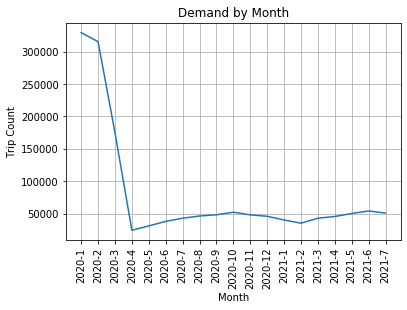

In [34]:
df_grouped = result_dominant_teams.groupby('year_month')[['trip_count']].sum().reset_index()

month_order = ['2020-1', '2020-2', '2020-3', '2020-4', '2020-5', '2020-6', '2020-7', '2020-8', '2020-9', '2020-10', '2020-11', '2020-12', '2021-1', '2021-2', '2021-3', '2021-4', '2021-5', '2021-6', '2021-7', '2021-8']
df_grouped['year_month'] = pd.Categorical(df_grouped['year_month'], categories=month_order, ordered=True)

# Sort the DataFrame by the categorical 'trip_day' column
df_sorted = df_grouped.sort_values(by='year_month')
df_sorted["year_month"] = df_sorted["year_month"].astype(str)
df_sorted = df_sorted[df_sorted['year_month'] != '2021-8']

# Plot using Matplotlib
plt.plot(df_sorted['year_month'], df_sorted['trip_count'], linestyle='-')
plt.xlabel('Month')
plt.ylabel('Trip Count')
plt.title('Demand by Month')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

#### Monthly Trip Counts Analysis (2020-2021):

- Overall Trend: Monthly trip counts fluctuate over the period, peaking at 329388 trips in Jan 2020 and dipping to 24,223 trips in April 2020.
- COVID-19 Impact: The significant drop in trip counts from March to June 2020 coincides with the onset of the COVID-19 pandemic, while recovery is observed in subsequent months.
- Steady Recovery: Trip counts gradually increase post-pandemic, with June 2021 showing a resurgence in activity.

#### Insights:

- Analyzing monthly trip trends provides insights into the impact of external factors such as the pandemic on transportation demand and recovery patterns over time.

#### Conclusion

- ##### Payment Preference: Electronic payments, particularly card transactions, dominate over cash payments across all analyzed dimensions.
- ##### Temporal Trends: Peak activity occurs on Wednesdays and Fridays, while Sundays witness the lowest trip counts. Weekly and monthly fluctuations reflect both regular patterns and the impact of external factors like the COVID-19 pandemic.
- ##### Borough Dynamics: Manhattan emerges as the primary hub for taxi trips, followed by Brooklyn, with significant activity in both card and cash transactions.
- ##### Insights for Operations: Understanding payment preferences, temporal patterns, and borough-wise dynamics facilitates optimized service provision, resource allocation, and marketing strategies.
- ##### Recovery Post-Pandemic: Monthly trip counts show a steady recovery post-COVID-19, indicating resilience in transportation demand over time.